# Model Output Notebook

<img style="float:center;" src="https://arcticexpansion.vse.gmu.edu/sites/arcticexpansion.vsnet.gmu.edu/files/images/header5d2.png" width=600px>

### ADCIRC-SWAN Output


### Initialize Libraries

In [1]:
import warnings;warnings.filterwarnings("ignore")
import netCDF4 as nc4;        import pandas as pd
import pathlib as pl;         import os
import numpy as np;           import xarray as xr
import geopandas as gpd;
from scipy import sparse
from scipy.sparse.csgraph import connected_components
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from functools import partial
from scipy.signal import find_peaks
from scipy.sparse import coo_matrix
from shapely.geometry import Point
import matplotlib.animation as animation

In [2]:
ds = xr.open_dataset("/scratch/tmiesse/project/surge_cluster_summary_48hr.nc")

In [3]:
x_all = ds["x"].values          # shape = (n_nodes,)
y_all = ds["y"].values          # shape = (n_nodes,)
ecpn  = ds["event_count_per_node"].values.astype(int)  # (n_nodes,)
nodes_df = pd.DataFrame({
    "x": x_all,
    "y": y_all,
    "event_count": ecpn
})
gdf_nodes = gpd.GeoDataFrame(
    nodes_df,
    geometry=[Point(x, y) for x, y in zip(nodes_df.x, nodes_df.y)],
    crs="EPSG:4326"
)

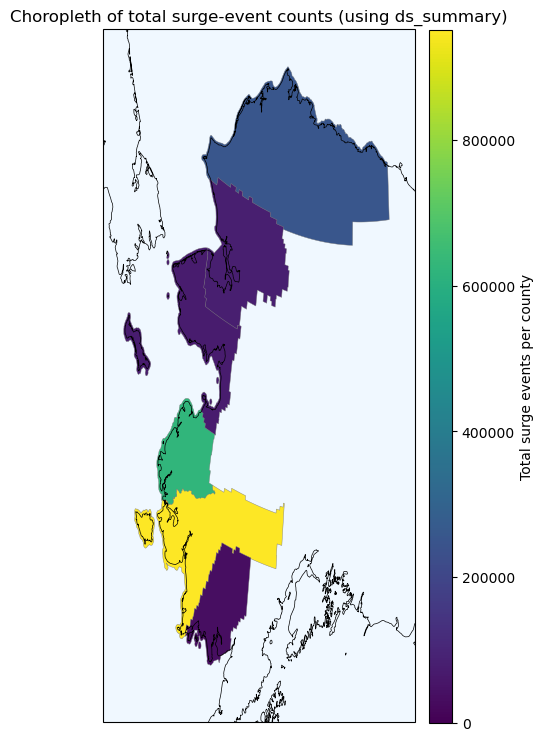

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt

# 4) Read your Alaska‐counties shapefile and buffer it slightly if you want to catch nearshore nodes:
counties = gpd.read_file("/scratch/tmiesse/project/counties/counties_wgs.shp")
counties = counties.to_crs("EPSG:3338")
# Buffer the geometry column by 1000 m:
counties["geometry"] = counties.geometry.buffer(1000)
# Go back to WGS84:
counties = counties.to_crs("EPSG:4326")
# Rename the county‐name column (if the original shapefile’s column is “CommunityN”)
counties = counties.rename(columns={"CommunityN": "county"})

# 5) Spatial‐join each node to its county (keep only nodes that fall inside)
joined = gpd.sjoin(
    gdf_nodes,
    counties[["county", "geometry"]],
    how="inner",
    predicate="within"
).drop(columns=["index_right"])

# 6) Sum up all node‐counts per county
county_counts = (
    joined
    .groupby("county")["event_count"]
    .sum()
    .reset_index(name="total_events")
)

# 7) Merge back onto counties GeoDataFrame
counties = counties.merge(county_counts, on="county", how="left")
counties["total_events"] = counties["total_events"].fillna(0).astype(int)

# 8) Plot a choropleth of “total_events” by county
fig = plt.figure(figsize=(9, 9))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-145))
ax.set_extent([-169, -140, 58, 71], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND.with_scale("10m"), facecolor="lightgray")
ax.add_feature(cfeature.OCEAN.with_scale("10m"), facecolor="aliceblue")
ax.coastlines(resolution="10m", linewidth=0.5)

vmin, vmax = 0, int(counties["total_events"].max())
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap("viridis")

counties.plot(
    column="total_events",
    cmap=cmap,
    norm=norm,
    linewidth=0.3,
    edgecolor="gray",
    ax=ax,
    transform=ccrs.PlateCarree()
)

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="vertical", pad=0.02, aspect=30)
cbar.set_label("Total surge events per county")

ax.set_title("Choropleth of total surge‐event counts (using ds_summary)")
plt.show()

In [5]:
# 0) your list & shapefile
counties_order = [
    "Lake and Peninsula Borough",
    "Dillingham Census Area",
    "Bethel Census Area",
    "Kusilvak Census Area",
    "Nome Census Area",
    "Northwest Arctic Borough",
    "North Slope Borough",
]
comms = (
    gpd.read_file("/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database/arctic_shapefiles/communities/City_Boundaries_wgs84.shp")
       .to_crs("EPSG:3338")
)
comms["geometry"] = comms.geometry.buffer(1)   # 1 m offshore buffer
comms = comms.to_crs("EPSG:4326")

# 1) Build the raw events table *including* each event’s node index:
#    event_local_idx[i] is the kept-node index for event i, 
#    times_s3[i]  is its timestamp.


In [21]:
df_nodes = pd.DataFrame({
    "node":             ds["node"].values,                   # shape = (n_nodes,)
    "x":                ds["x"].values,                      # lon
    "y":                ds["y"].values,                      # lat
    "node_event_count": ds["event_count_per_node"].values,   # total events per node
})

gdf_nodes = gpd.GeoDataFrame(
    df_nodes,
    geometry=[Point(lon, lat) for lon, lat in zip(df_nodes["x"], df_nodes["y"])],
    crs="EPSG:4326",
)

# Reproject to a METRIC CRS so distances are in meters (use Alaska Albers EPSG:3338)
gdf_nodes_proj = gdf_nodes.to_crs(epsg=3338)

# Free up df_nodes if you want, but not strictly necessary
# del df_nodes


# ---------------------------------------------------------------------------#
# 3)  READ AND BUFFER COMMUNITY POLYGONS
# ---------------------------------------------------------------------------#
com_pt_shp = (
    "/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database/arctic_shapefiles/comm_and_flood/community_pt.shp"
)
gdf_com_pts = (
    gpd.read_file(com_pt_shp)
       .to_crs(epsg=4326)  
       .rename(columns={"CommunityN": "community"}, errors="ignore")
       # If the shapefile’s community‐name column is named differently, adjust above
)

# Reproject to EPSG:3338 for metric buffering
gdf_com_pts_proj = gdf_com_pts.to_crs(epsg=3338)

# Buffer each point by 300 m
gdf_com_pts_proj["geometry"] = gdf_com_pts_proj.geometry.buffer(500)

# Now gdf_com_pts_proj has one polygon per community (a 300 m circle around each original point)


# ---------------------------------------------------------------------------#
# 4)  FIND NODES INSIDE EACH BUFFER & PICK THE NEAREST
# ---------------------------------------------------------------------------#
# Spatial‐join: find all nodes that lie within each buffered polygon
joined = gpd.sjoin(
    gdf_nodes_proj[["node", "geometry", "node_event_count"]],
    gdf_com_pts_proj[["community", "geometry"]],
    how="inner",
    predicate="within"
)
# joined columns: [index_left, node, geometry(node), node_event_count, index_right, community, geometry(buffer)]

# If a community has multiple nodes in its 300 m buffer, we want the node nearest to the original point.
# To do that, we need each buffered‐polygon’s original center. Let’s get centroids of gdf_com_pts_proj:
gdf_centroids = gdf_com_pts_proj.copy()
gdf_centroids["centroid"] = gdf_centroids.geometry.centroid

# Build a lookup: community → centroid‐Point (EPSG:3338)
comm_to_centroid = dict(zip(
    gdf_centroids["community"], 
    gdf_centroids["centroid"]
))

# For each community, among the nodes in joined, pick the node with minimum distance to centroid
comm_to_node = {}

for comm, subset in joined.groupby("community"):
    centroid = comm_to_centroid[comm]
    # Compute distances from each node point (in joined) to centroid
    # Note: joined.geometry here is the node’s geometry (in EPSG:3338)
    dists = subset.geometry.distance(centroid)
    # Pick the row with the smallest distance
    idx_min = dists.idxmin()
    nearest_node = int(joined.loc[idx_min, "node"])
    comm_to_node[comm] = nearest_node

print(f"Number of communities matched to a node within 300 m: {len(comm_to_node)} / {len(gdf_com_pts_proj)}")


# ---------------------------------------------------------------------------#
# 5)  EXTRACT EVENT YEARS
#     We rely on ds["time"] (length = n_events) to get each event’s calendar year.
# ---------------------------------------------------------------------------#
if "time" not in ds.coords:
    raise KeyError("NetCDF must have a 'time' coordinate (datetime64).")

event_times = pd.to_datetime(ds["time"].values)   # shape = (n_events,)
event_years = event_times.year.astype(int)        # NumPy array of ints

print(f"Events span years {event_years.min()}–{event_years.max()}")


# ---------------------------------------------------------------------------#
# 6)  COUNT DISTINCT EVENTS PER COMMUNITY PER YEAR
# ---------------------------------------------------------------------------#
comm_year_counts: dict[str, dict[int, int]] = {}

for community_name, node_idx in comm_to_node.items():
    # Select component array for that single node: dims = (event,)
    comp_node = ds["component"].sel(node=node_idx)  # DataArray
    # hits_bool[i] = True if event i flooded this node (component ≥ 0)
    hits_bool = (comp_node >= 0).values.reshape(-1)  # boolean array length = n_events
    
    # Extract the years of events that hit
    years_hit = event_years[hits_bool]  # e.g. array([1981,1981,1983,2005,...])
    
    # Count how many hits in each year
    counts_series = pd.value_counts(years_hit, sort=False)
    year_dict = {int(yr): int(counts_series[yr]) for yr in counts_series.index}

    # OPTIONAL: Zero‐fill all years:
    # all_years = range(event_years.min(), event_years.max() + 1)
    # year_dict = {yr: int(year_dict.get(yr, 0)) for yr in all_years}

    comm_year_counts[community_name] = year_dict


Number of communities matched to a node within 300 m: 22 / 45
Events span years 1981–2024


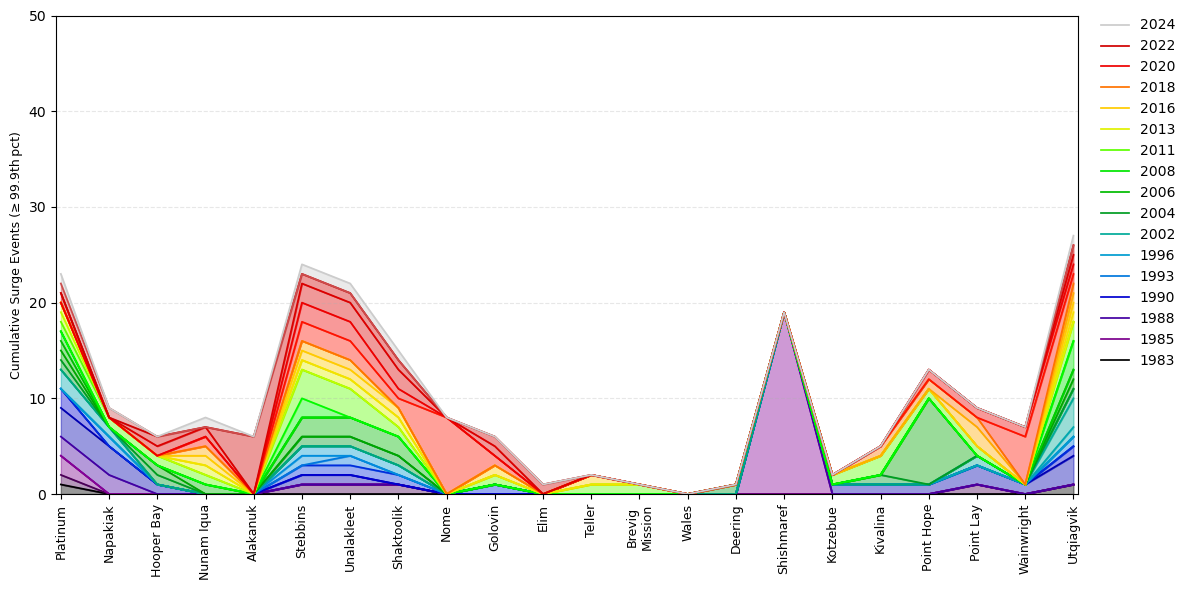

In [22]:
import textwrap
com_pt_shp = "/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database/arctic_shapefiles/comm_and_flood/community_pt.shp"
gdf_com_pts = (
    gpd.read_file(com_pt_shp)
       .to_crs(epsg=4326)
       .rename(columns={"CommunityN": "community"}, errors="ignore")
)

# Extract latitude for each community point (geometry is a Point in EPSG:4326)
gdf_com_pts["latitude"] = gdf_com_pts.geometry.y

# Keep only communities that appear in comm_year_counts
gdf_com_pts = gdf_com_pts[gdf_com_pts["community"].isin(comm_year_counts.keys())]

# Sort communities by latitude (south → north)
gdf_com_pts_sorted = gdf_com_pts.sort_values("latitude", ascending=True)
communities_order = list(gdf_com_pts_sorted["community"])


# ─────────── 2)  FLATTEN comm_year_counts → DataFrame ───────────
rows = []
for community_name, yearly_dict in comm_year_counts.items():
    for yr_str, cnt in yearly_dict.items():
        year = int(yr_str)
        rows.append({
            "community": community_name,
            "year":      year,
            "count":     cnt
        })

df_comm = pd.DataFrame(rows)


# ─────────── 3)  PIVOT TO years × communities TABLE ───────────
df_pivot = (
    df_comm
      .pivot(index="year", columns="community", values="count")
      .reindex(columns=communities_order)  # enforce south→north community order
      .fillna(0)
)

# ─────────── 4)  CUMULATIVE SUM DOWN EACH COMMUNITY ───────────
cum = df_pivot.cumsum(axis=0)


# ─────────── 5)  PLOT AS STACKED “FILL BETWEEN” ───────────
x      = np.arange(len(communities_order))
years  = cum.index.values
cmap   = plt.get_cmap("nipy_spectral", len(years))

fig, ax = plt.subplots(figsize=(12, 6))
prev = np.zeros(len(communities_order))

for i, yr in enumerate(years):
    y     = cum.loc[yr].values
    color = cmap(i)
    ax.fill_between(x, prev, y, color=color, alpha=0.4)
    ax.plot(x, y, color=color, linewidth=1.25, label=str(yr))
    prev = y

ax.set_xticks(x)
ax.set_xticklabels(communities_order, rotation=90, ha="right", fontsize=9)
ax.set_ylabel("Cumulative Surge Events (≥ 99.9th pct)", fontsize=9)

ax.set_xlim(x[0] - 0.1, x[-1] + 0.1)

# Wrap long community names to two lines (width = 12 chars)
def wrap_labels(ax, width, break_long_words=False):
    new_labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        new_labels.append(textwrap.fill(text, width=width, break_long_words=break_long_words))
    ax.set_xticklabels(new_labels, rotation=90, ha="center")

wrap_labels(ax, 12)

# Legend: show only first, middle, last year
handles, labels = ax.get_legend_handles_labels()
sample_years = [years[0], years[len(years)//2], years[-1]]
sample_labels = [str(y) for y in sample_years]
pick_indices = [labels.index(lbl) for lbl in sample_labels]
pick_handles = [handles[i] for i in pick_indices]
pick_labels  = [labels[i] for i in pick_indices]
ax.set_ylim([0,50])
ax.legend(
    handles[::-2],
    labels[::-2],
    loc="upper left",
    bbox_to_anchor=(1.01, 1.02),
    ncol=1,
    fontsize=10,
    frameon=False
)

ax.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:


gdf_ev = gpd.GeoDataFrame(
    events,
    geometry=[Point(lon, lat) for lon,lat in zip(x_nodes, y_nodes)],
    crs="EPSG:4326"
)

# 3) Spatial‐join → each event now has a "county" label
gdf = (
    gpd.sjoin(
        gdf_ev,
        comms[["CommunityN","geometry"]],
        how="left",
        predicate="intersects"
    )
    .drop(columns=["index_right"])
)
# drop any events that never landed in a county polygon
gdf = gdf.dropna(subset=["CommunityN"])

# 4) Exclude the partial 1981 if you like
#gdf = gdf[gdf.year != 1981]

# 5) Count events *per node* in each (county, year)
df_node = (
    gdf
    .groupby(["CommunityN","year","node"])
    .size()
    .reset_index(name="node_event_count")
)

# 6) Average across nodes → one value per (county, year)
df_avg = (
    df_node
    .groupby(["county","year"])["node_event_count"]
    .median()
    .reset_index(name="avg_events_per_node")
)

# 7) Pivot to get a years×counties table, in your desired order
df_yearly_avg = (
    df_avg
    .pivot(index="year",
           columns="CommunityN",
           values="avg_events_per_node")
    .reindex(columns=counties_order).fillna(0)
    # if you’d rather see NaN for truly‐missing counties instead of zeros:
    # .fillna(0)
)

# 8) Cumulative sum down each county
cum = df_yearly_avg.cumsum(axis=0)

# 9) Finally, plot exactly as you had it
import matplotlib.pyplot as plt

x      = np.arange(len(counties_order))
years  = cum.index.values
cmap   = plt.get_cmap("nipy_spectral", len(years))

fig, ax = plt.subplots(figsize=(12,6))
prev = np.zeros(len(counties_order))

for i, yr in enumerate(years):
    y     = cum.loc[yr].values
    color = cmap(i)
    ax.fill_between(x, prev, y, color=color, alpha=0.4)
    ax.plot(x, y, color=color, linewidth=1.25, label=str(yr))
    prev = y

ax.set_xticks(x)
ax.set_xticklabels(counties_order, rotation=90, ha="right",fontsize=9)
ax.set_ylabel("Cumulative Surge Events that exceeded 99.9th Percentile",fontsize=9)
ax.set_ylim([0,75]),ax.set_xlim(x[0] - 0.05, x[-1] + 0.05)
#ax.set_title("Year‐by‐year cumulative average node‑events by county")

# Legend: first, middle, last
handles, labels = ax.get_legend_handles_labels()
sample_years = [years[0], years[len(years)//2], years[-1]]

#sel_l = [labels.index(str(y)) for y in sample_years]
#sel_h = [handles.index(str(y)) for y in sample_years]
import textwrap

def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width, break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=90,ha="center")
wrap_labels(ax, 10) # Wrap labels at a width of 10 characters
ax.legend(
    handles[::-2],
    labels[::-2],
    loc="upper left",
    bbox_to_anchor=(1.01, 1.02),
    ncol=1,
    fontsize=10,
    frameon=False
)

ax.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig(
    '/scratch/tmiesse/project/figures/cumulative_events.png',
    dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

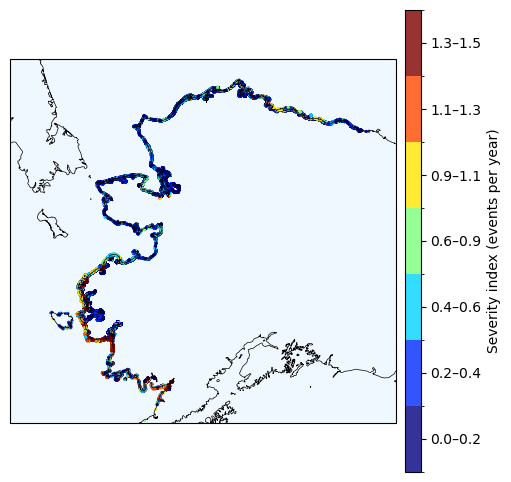

In [ ]:
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# 3) Decide how many years your record spans.  For example, if your simulation
#    covers 1981–2023 inclusive, that’s 43 years:
n_years = 42

# 4) Compute a per‑node severity index = (total events at node) / (n_years)
severity_index = total_events / n_years       # shape = (n_nodes,)
n_bins = 7
vmin = 0.0
vmax = 1.5#float(np.nanmax(severity_index))
# 5) Now plot each node on a Cartopy map, colored by severity_index
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-145))
ax.set_extent([-169, -140, 58, 71], crs=ccrs.PlateCarree())

# Base layers
ax.add_feature(cfeature.LAND.with_scale("10m"), facecolor="lightgray")
ax.add_feature(cfeature.OCEAN.with_scale("10m"), facecolor="aliceblue")
ax.coastlines(resolution="10m", linewidth=0.5)

boundaries = np.linspace(vmin, vmax, n_bins + 1)  # length = n_bins+1
tick_positions = (boundaries[:-1] + boundaries[1:]) / 2  # length = n_bins
tick_labels = [
    f"{boundaries[i]:.1f}–{boundaries[i+1]:.1f}"
    for i in range(n_bins)
]

# 6) Create a discrete colormap + norm
cmap = plt.get_cmap("jet", n_bins)      # “magma” with n_bins distinct colors
norm = BoundaryNorm(boundaries, ncolors=n_bins)


# Scatter every node, sized small so coastal features show up
sc = ax.scatter(
    x_all,
    y_all,
    c=severity_index,
    s=5,
    edgecolor="none",
    cmap=cmap,
    norm=norm,
    transform=ccrs.PlateCarree(),
    linewidth=0,
    alpha=0.8
)

# 10) Create a colorbar using the bin centers and labels
cbar = plt.colorbar(
    sc,
    ax=ax,
    orientation="vertical",
    ticks=tick_positions,
    pad=0.02,
    aspect=30

)
cbar.set_label("Severity index (events per year)")
cbar.ax.set_yticklabels(tick_labels)

plt.show()

In [4]:
import cartopy.crs as ccrs;   import cartopy.io.img_tiles as cart_img
import cartopy as cart;       import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import matplotlib.tri as mtri
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import ScalarMappable

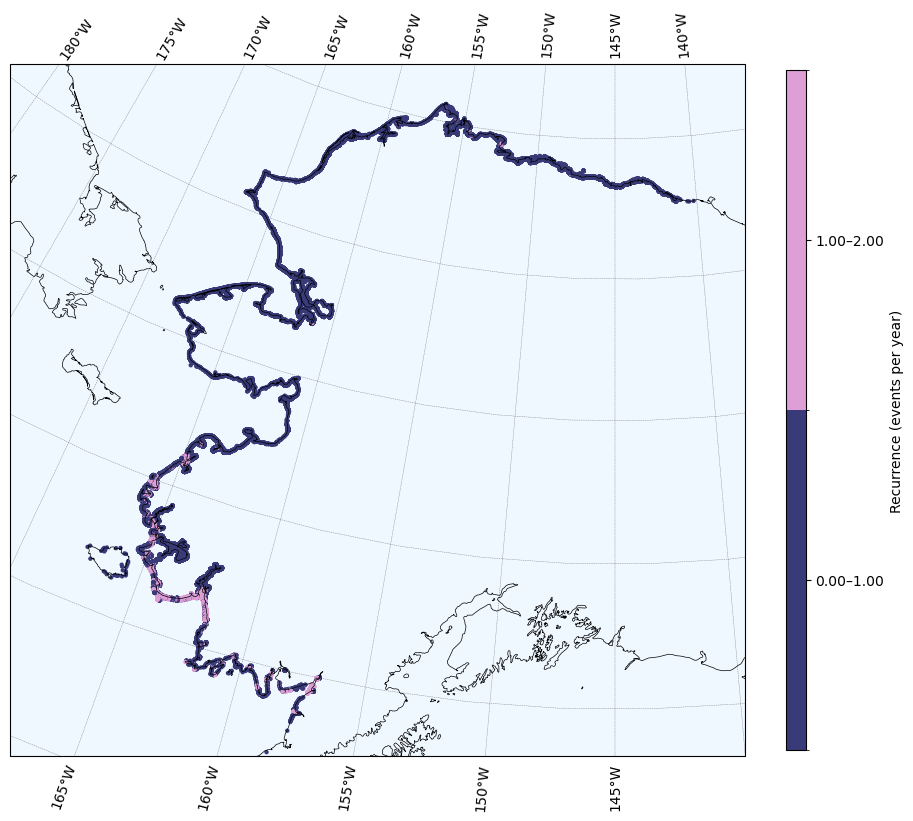

In [42]:

event_count = ds["event_count_per_node"].values   # shape = (n_nodes,)
x_nodes     = ds["x"].values                      # shape = (n_nodes,)
y_nodes     = ds["y"].values                      # shape = (n_nodes,)

# 3) Decide how many years your record spans
n_years = 44

# 4) Compute the recurrence rate: events per year at each node

recurrence = np.zeros(event_count.shape)  # Initialize recurrence to zero
for i in range(len(event_count)):
    recurrence[i] = event_count[i] / n_years

# 5) Set up discrete bins for coloring the recurrence rate
n_bins = 2
vmin, vmax = 0,2#recurrence.min(), recurrence.max()
boundaries = np.linspace(vmin, vmax, n_bins + 1)

# 6) Create a colormap with n_bins discrete colors and a BoundaryNorm
cmap = plt.get_cmap("tab20b", n_bins)
norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=True)

# 7) Prepare tick locations and labels for the colorbar.
#    We place ticks at the midpoint of each bin and label as "low–high".
tick_locs = (boundaries[:-1] + boundaries[1:]) / 2
tick_labels = [
    f"{boundaries[i]:.2f}–{boundaries[i+1]:.2f}"
    for i in range(n_bins)
]

# 8) Create the Cartopy figure
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-145))

# 9) Restrict the view to roughly the Alaskan coastline
lon_min, lon_max = -169, -140
lat_min, lat_max =  58,   71
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# 10) Add base features (land, ocean, coastlines, gridlines)
ax.add_feature(cfeature.LAND,  facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="aliceblue")
ax.coastlines(resolution="10m", linewidth=0.5)

gl = ax.gridlines(
    xlocs=np.arange(-180, -100, 5),
    ylocs=np.arange(  50,   90, 3),
    draw_labels=True,
    linewidth=0.3,
    color="black",
    alpha=0.5,
    linestyle="--"
)
gl.xlabels_top    = False
gl.xlabels_bottom = True
gl.ylables_left   = False
gl.ylables_right  = True
gl.xformatter     = ccrs.cartopy.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter     = ccrs.cartopy.mpl.gridliner.LATITUDE_FORMATTER

# 11) Scatter-plot each node, colored by its recurrence rate (events/year)
sc = ax.scatter(
    x_nodes,
    y_nodes,
    c=recurrence,
    cmap=cmap,
    norm=norm,
    s=10,
    transform=ccrs.PlateCarree(),
    edgecolors="none"
)

# 12) Create a colorbar next to the map, with custom tick labels
cbar_ax = fig.add_axes([1.01, 0.075, 0.025, 0.85])
cbar = fig.colorbar(
    ScalarMappable(norm=norm, cmap=cmap),
    cax=cbar_ax,
    ticks=tick_locs,
    orientation="vertical"
)
cbar.set_label("Recurrence (events per year)")
cbar.ax.set_yticklabels(tick_labels)

# 13) Final touches: title and show

plt.tight_layout()
plt.show()

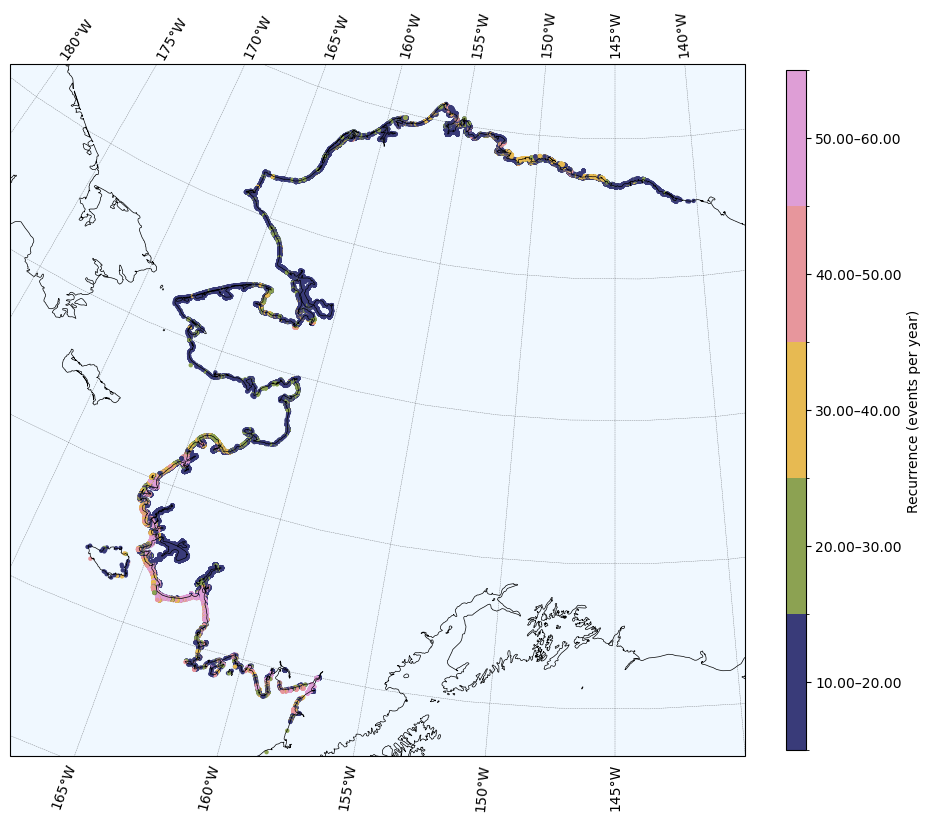

In [45]:

event_count = ds["event_count_per_node"].values   # shape = (n_nodes,)
x_nodes     = ds["x"].values                      # shape = (n_nodes,)
y_nodes     = ds["y"].values                      # shape = (n_nodes,)

# 3) Decide how many years your record spans


# 5) Set up discrete bins for coloring the recurrence rate
n_bins = 5
vmin, vmax = 10,60#recurrence.min(), recurrence.max()
boundaries = np.linspace(vmin, vmax, n_bins + 1)

# 6) Create a colormap with n_bins discrete colors and a BoundaryNorm
cmap = plt.get_cmap("tab20b", n_bins)
norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=True)

# 7) Prepare tick locations and labels for the colorbar.
#    We place ticks at the midpoint of each bin and label as "low–high".
tick_locs = (boundaries[:-1] + boundaries[1:]) / 2
tick_labels = [
    f"{boundaries[i]:.2f}–{boundaries[i+1]:.2f}"
    for i in range(n_bins)
]

# 8) Create the Cartopy figure
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-145))

# 9) Restrict the view to roughly the Alaskan coastline
lon_min, lon_max = -169, -140
lat_min, lat_max =  58,   71
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# 10) Add base features (land, ocean, coastlines, gridlines)
ax.add_feature(cfeature.LAND,  facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="aliceblue")
ax.coastlines(resolution="10m", linewidth=0.5)

gl = ax.gridlines(
    xlocs=np.arange(-180, -100, 5),
    ylocs=np.arange(  50,   90, 3),
    draw_labels=True,
    linewidth=0.3,
    color="black",
    alpha=0.5,
    linestyle="--"
)
gl.xlabels_top    = False
gl.xlabels_bottom = True
gl.ylables_left   = False
gl.ylables_right  = True
gl.xformatter     = ccrs.cartopy.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter     = ccrs.cartopy.mpl.gridliner.LATITUDE_FORMATTER

# 11) Scatter-plot each node, colored by its recurrence rate (events/year)
sc = ax.scatter(
    x_nodes,
    y_nodes,
    c=event_count,
    cmap=cmap,
    norm=norm,
    s=10,
    transform=ccrs.PlateCarree(),
    edgecolors="none"
)

# 12) Create a colorbar next to the map, with custom tick labels
cbar_ax = fig.add_axes([1.01, 0.075, 0.025, 0.85])
cbar = fig.colorbar(
    ScalarMappable(norm=norm, cmap=cmap),
    cax=cbar_ax,
    ticks=tick_locs,
    orientation="vertical"
)
cbar.set_label("Recurrence (events per year)")
cbar.ax.set_yticklabels(tick_labels)

# 13) Final touches: title and show

plt.tight_layout()
plt.show()

In [40]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# 1) Build a pandas DataFrame for shallow‐water nodes
df = pd.DataFrame({
    "x":           x_nodes,    # X coordinates
    "y":           y_nodes,    # Y coordinates
    "event_count": recurrence               # events per node
})

# 2) Create Point geometries
df["geometry"] = [Point(x, y) for x, y in zip(df.x, df.y)]

# 3) Convert to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# 4) Save to a shapefile
out_path = "/scratch/tmiesse/project/event_count/recurrence.shp"
gdf.to_file(out_path)

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
ev_times = pd.to_datetime(ds["time"].values)  # shape = (n_events,)

# -------------------------------------------------------------------
# 2) Identify all event‐indices that fall within Merbok’s window
#    (roughly late September → mid October 2022)
# -------------------------------------------------------------------
start = pd.to_datetime("2022-09-15")
end   = pd.to_datetime("2022-09-18")

mask_merbok = (ev_times >= start) & (ev_times <= end)
candidates  = np.nonzero(mask_merbok)[0]  # e.g. array([ … indices … ])

if len(candidates) == 0:
    raise RuntimeError("No Merbok‐window events found in that date range.")

print("Found Merbok candidate event‐indices:", candidates)
print("Corresponding timestamps:   ", ev_times[candidates])

# -------------------------------------------------------------------
# 3) Grab the kept‐node X/Y once (these never change per frame)
# -------------------------------------------------------------------
x_kept = ds["x"].values    # shape = (n_kept,)
y_kept = ds["y"].values    # shape = (n_kept,)

# -------------------------------------------------------------------
# 4) Define a helper to get a boolean “flood mask” for a given event
# -------------------------------------------------------------------
def get_flood_mask(event_idx):
    """
    Return a Boolean mask of length n_kept, True wherever ds['component']
    for this event >= 0 (i.e. that node flooded in this event).
    """
    comp_labels = ds["component"].isel(event=event_idx).values
    return comp_labels >= 0  # boolean array of length n_kept

# -------------------------------------------------------------------
# 5) Build a Matplotlib figure + Cartopy axes that we will update
#    for each Merbok‐candidate frame.
# -------------------------------------------------------------------
fig = plt.figure(figsize=(8, 8))
ax  = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-145))
ax.set_extent([-169, -140, 58, 71], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND,  facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="aliceblue")
ax.coastlines(resolution="10m", linewidth=0.5)

# Pre‐create two scatter collections:
#   sc_non → all kept nodes that are NOT flooding in this frame (light gray)
#   sc_fld → all kept nodes that ARE flooding in this frame (crimson)
sc_non = ax.scatter([], [], s=1, color="lightgray",
                    transform=ccrs.PlateCarree(), zorder=1, edgecolors="none")
sc_fld = ax.scatter([], [], s=8, color="crimson",
                    transform=ccrs.PlateCarree(), zorder=2, edgecolors="none")

# A dynamic title text object (we'll update each frame with the event timestamp)
title = ax.text(0.5, 1.02, "", transform=ax.transAxes,
                ha="center", va="bottom", fontsize=12, fontweight="bold")

# -------------------------------------------------------------------
# 6) Create the update(frame) callback for FuncAnimation
# -------------------------------------------------------------------
def update(frame_number):
    """
    Called once per frame.  'frame_number' runs 0..len(candidates)-1.
    We look up the actual event index as candidates[frame_number],
    then build the two scatter offsets for flooded vs non‐flooded nodes.
    """
    idx = candidates[frame_number]          # the event‐index in ds.event
    mask = get_flood_mask(idx)               # boolean mask length=n_kept

    # Split kept nodes into flooded vs. non‐flooded
    x_flood = x_kept[mask]
    y_flood = y_kept[mask]
    x_non   = x_kept[~mask]
    y_non   = y_kept[~mask]

    # Update scatter offsets
    sc_non.set_offsets(np.column_stack([x_non, y_non]))
    sc_fld.set_offsets(np.column_stack([x_flood, y_flood]))

    # Update the title with the exact timestamp
    event_time = ev_times[idx]  # e.g. 2022-09-28T13:00:00
    title.set_text(f"Merbok footprint – {event_time:%Y-%m-%d %H:%M}")
    return sc_non, sc_fld, title

# -------------------------------------------------------------------
# 7) Build and save the animation using FFMpegWriter
# -------------------------------------------------------------------
num_frames = len(candidates)
anim = animation.FuncAnimation(
    fig,            # figure we created
    update,         # update function
    frames=num_frames,
    interval=1000,  # 1000 ms between frames (adjust as desired)
    blit=True
)

# Ensure ffmpeg is on your PATH; choose fps=1 (1 frame/sec)
writer = animation.FFMpegWriter(
    fps=1,
    metadata=dict(artist="surge‐tracking"),
    bitrate=3000
)

output_path = "/scratch/tmiesse/project/merbok_footprint_movie.mp4"
anim.save(output_path, writer=writer)
print("Saved Merbok movie →", output_path)

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm



lat1, lat2 = 58, 71
lon1, lon2 = -167, -140
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
use_code = True

if use_code:
    cvals = ds_events["cluster"].values
    cmap  = "tab10"
    clabel = "Cluster Code"
else:
    # if you want to map names to integers, do that:
    names = ds_events["cluster"].values  # string cluster names
    unique, inv = np.unique(names, return_inverse=True)
    cvals = inv
    cmap  = "tab20"
    clabel = "Cluster Name"

# 2) Cluster those peak‐locations
names = ds_events["cluster"].values   # e.g. ['Bristol Bay Borough', ...] length = n_events
lon   = x_peak                              # your array of peak longitudes
lat   = y_peak                              # your array of peak latitudes

# 2) Build a mapping name→integer
unique_names, inv = np.unique(names, return_inverse=True)
# unique_names  shape = (n_clusters,)
# inv           shape = (n_events,) where inv[i] is the integer code for names[i]

# 3) Prepare discrete colormap & norm
nclus = unique_names.size
cmap  = plt.get_cmap("tab20", nclus)
norm  = BoundaryNorm(boundaries=np.arange(nclus+1)-0.5, ncolors=nclus)

# 4) Make the map
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-145))
ax.set_extent([-169, -140, 58, 71], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,  facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="aliceblue")
ax.coastlines(resolution="10m", linewidth=0.5)

# 5) Scatter using the integer codes
sc = ax.scatter(
    lon, lat,
    c=inv,
    cmap=cmap,
    norm=norm,
    s=30,
    edgecolor="k",
    linewidth=0.2,
    transform=ccrs.PlateCarree()
)

# 6) Add discrete colorbar with text labels
cbar = plt.colorbar(sc, ax=ax, pad=0.02, aspect=30, ticks=np.arange(nclus))
cbar.ax.set_yticklabels(unique_names)
cbar.set_label(" Cluster")

plt.title("Surge Events by Cluster")
#plt.savefig(
#    '/scratch/tmiesse/project/figures/test.png',
#    dpi=300, bbox_inches='tight', pad_inches=0.1
#)
plt.show()

In [ ]:
sample = pl.Path(root)/"2023"/"fort.63.cf.nc"
ds0    = xr.open_dataset(str(sample), engine="netcdf4", mask_and_scale=False)
x_all  = ds0.x.values                          # (n_nodes,)
y_all  = ds0.y.values                          # (n_nodes,)
# connectivity: drop time dim, zero‑base
conn0    = ds0.face_node_connectivity.values - 1  # now shape (nele, 3)
ds0.close()
